<a href="https://colab.research.google.com/github/g2246462796/dive_into_deep_learning/blob/main/6_%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6 卷积神经网络

## 6.1 从全连接层到卷积

对于表格数据，我们寻找的模式可能涉及特征之间的交互，但是我们不能预先假设任何与特征交互相关的先验结构。 此时，多层感知机可能是最好的选择

然而对于高维感知数据，这种缺少结构的网络可能会变得不实用（因为需要非常大数量级的节点和参数，且效果不一定好）

然而，如今人类和机器都能很好地区分猫和狗：这是因为图像中本就拥有丰富的结构，而这些结构可以被人类和机器学习模型使用。 卷积神经网络（convolutional neural networks，CNN）是机器**学习利用自然图像中一些已知结构**的创造性方法。

## 6.1.1 不变性

我们认为寻找物体首先和物体本身的位置没有关系。检测器将图片分割为若干个小区域，然后对于每个区域，为包含物体的可能性打分。

卷积神经网络就是将空间不变性这一概念系统化，基于这个模型来使用较少的参数学习使用。

现在，我们将上述想法总结一下，从而帮助我们设计适合于计算机视觉的神经网络架构。

平移不变性（translation invariance）：不管检测对象出现在图像中的哪个位置，**神经网络的前面几层应该对相同的图像区域具有相似的反应**，即为“平移不变性”。

局部性（locality）：神经网络的前面几层应该只探索输入图像中的局部区域，而**不过度在意图像中相隔较远区域的关系**，这就是“局部性”原则。**最终，可以聚合这些局部特征**，以在整个图像级别进行预测。

# 6.2 图像卷积

## 6.2.1 互相关运算

严格来说，卷积层是个错误的叫法，**因为它所表达的运算其实是互相关运算（cross-correlation），而不是卷积运算**。 根据 6.1节中的描述，在卷积层中，输入张量和核张量通过互相关运算产生输出张量。

下面是进行互相关运算的函数（2维）实现

In [ ]:
import torch
from torch import nn

def corr2d(X,K):
  """计算二维互相关运算"""
  h,w = K.shape
  Y = torch.zeros((X.shape[0]-h+1,X.shape[1]-w+1))
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      Y[i,j] = (X[i:i+h,j:j+w]*K).sum()
  return Y

测试函数功能

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## 6.2.2 卷积层

卷积层对输入和卷积核权重进行互相关运算，并在添加标量偏置之后产生输出。 所以，卷积层中的两个被训练的参数是卷积核权重和标量偏置。 就像我们之前随机初始化全连接层一样，在训练基于卷积层的模型时，我们也随机初始化卷积核权重。

实现二维卷积层

In [ ]:
class Conv2D(nn.Module):
  def __init__(self,kernel_size):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(kernel_size))
    self.bias = nn.Parameter(torch.zeros(1))

  def forward(self,x):
    return corr2d(x,self.weight)+self.bias

## 6.2.3. 图像中目标的边缘检测

In [ ]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

卷积核 2*1

In [ ]:
K = torch.tensor([[1.0, -1.0]])

互相关计算

In [ ]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

转置后再互相关运算

In [ ]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## 6.2.4 学习卷积核

In [ ]:
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 11.527
epoch 4, loss 2.574
epoch 6, loss 0.694
epoch 8, loss 0.224
epoch 10, loss 0.082


In [ ]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9902, -0.9752]])

# 6.3 填充和步幅

卷积的输出形状取决于输入形状和卷积核的形状。

还有什么因素会影响输出的大小呢？本节我们将介绍填充（padding）和步幅（stride）

## 6.3.1 填充

在应用多层卷积时，我们常常丢失边缘像素。 由于我们通常使用小卷积核，因此对于任何单个卷积，我们可能只会丢失几个像素。 但随着我们应用许多连续卷积层，累积丢失的像素数就多了。

填充实际上就是在边界填充数值，这样减缓了丢失边缘像素的速度。

卷积神经网络中卷积核的**高度和宽度通常为奇数**，例如1、3、5或7。 选择奇数的好处是，保持空间维度的同时，我们可以在顶部和底部填充相同数量的行，在左侧和右侧填充相同数量的列。

In [ ]:
import torch
from torch import nn


# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示批量大小和通道数都是1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

当卷积核的高度和宽度不同时，我们可以填充不同的高度和宽度，使输出和输入具有相同的高度和宽度。

In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

## 6.3.2. 步幅

在计算互相关时，卷积窗口从输入张量的左上角开始，向下、向右滑动。 在前面的例子中，我们默认每次滑动一个元素。 但是，有时候为了高效计算或是缩减采样次数，**卷积窗口可以跳过中间位置，每次滑动多个元素**。

我们将每次滑动元素的数量称为步幅（stride）。

In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## 6.3.3. 小结

# 6.4. 多输入多输出通道

虽然我们在 6.1.4.1节中描述了构成每个图像的多个通道和多层卷积层。例如彩色图像具有标准的RGB通道来代表红、绿和蓝。 但是到目前为止，我们仅展示了单个输入和单个输出通道的简化例子。 这使得我们可以将输入、卷积核和输出看作二维张量。

当我们添加通道时，输入和隐藏的表示都变成了三维张量。例如，每个RGB输入图像具有3xhxw的形状。
这个大小为3的轴称为通道轴。

In [ ]:
import torch

def corr2d_multi_in(X,k):
  # 先遍历"X"和"k"的第0个维度，再加到一起
  return sum(corr2d(x,k) for x,k in zip(X,K))

验证

In [ ]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

## 6.4.2. 多输出通道

到目前为止，不论有多少输入通道，我们还只有一个输出通道。然而，正如我们在 6.1.4.1节中所讨论的，每一层有多个输出通道是至关重要的。在最流行的神经网络架构中，随着神经网络层数的加深，我们常会增加输出通道的维数，通过减少空间分辨率以获得更大的通道深度。**直观地说，我们可以将每个通道看作对不同特征的响应。**而现实可能更为复杂一些，因为每个通道不是独立学习的，而是为了共同使用而优化的。因此，多输出通道并不仅是学习多个单通道的检测器。

In [ ]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [ ]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

## 6.4.3 1X1卷积层

In [ ]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [ ]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X,K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

# 6.5 汇聚层

通常当我们处理图像时，我们希望逐渐降低隐藏表示的空间分辨率、聚集信息，这样随着我们在神经网络中层叠的上升**，每个神经元对其敏感的感受野（输入）就越大**。

而我们的机器学习任务通常会跟全局图像的问题有关（例如，“图像是否包含一只猫呢？”），所以我们最后一层的神经元应该对整个输入的全局敏感。**通过逐渐聚合信息，生成越来越粗糙的映射，最终实现学习全局表示的目标，同时将卷积图层的所有优势保留在中间层**。

此外，当检测较底层的特征时（例如 6.2节中所讨论的边缘），我们通常希望这些特征保持某种程度上的平移不变性。例如，如果我们拍摄黑白之间轮廓清晰的图像X，并将整个图像向右移动一个像素，即Z[i, j] = X[i, j + 1]，则新图像Z的输出可能大不相同。而在现实中，随着拍摄角度的移动，任何物体几乎不可能发生在同一像素上。即使用三脚架拍摄一个静止的物体，由于快门的移动而引起的相机振动，可能会使所有物体左右移动一个像素（除了高端相机配备了特殊功能来解决这个问题）。

本节将介绍汇聚（pooling）层，它具有双重目的：降低卷积层对位置的敏感性，同时降低对空间降采样表示的敏感性。

## 6.5.1 最大汇聚层和平均汇聚层

与卷积层类似，汇聚层运算符由一个固定形状的窗口组成，该窗口根据其步幅大小在输入的所有区域上滑动，为固定形状窗口（有时称为汇聚窗口）遍历的每个位置计算一个输出。 然而，不同于卷积层中的输入与卷积核之间的互相关计算，汇聚层不包含参数。 相反，池运算是确定性的，**我们通常计算汇聚窗口中所有元素的最大值或平均值**。这些操作分别称为最大汇聚层（maximum pooling）和平均汇聚层（average pooling）。

在这两种情况下，与互相关运算符一样，汇聚窗口从输入张量的左上角开始，从左往右、从上往下的在输入张量内滑动。在汇聚窗口到达的每个位置，它计算该窗口中输入子张量的最大值或平均值。计算最大值或平均值是取决于使用了最大汇聚层还是平均汇聚层。

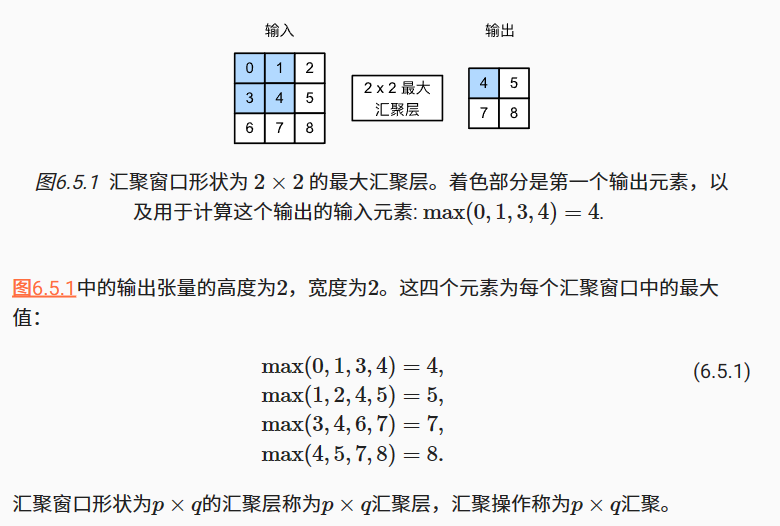

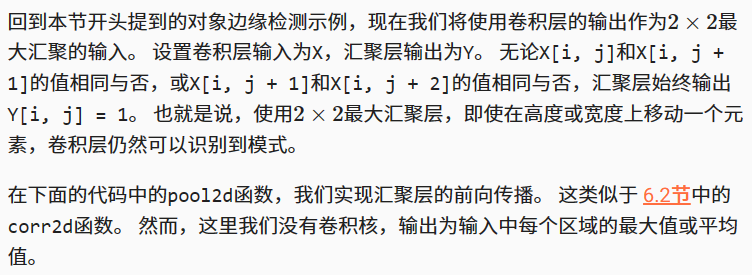

In [ ]:
import torch
from torch import nn

def pool2d(X,pool_size,mode='max'):
  p_h,p_w = pool_size
  Y = torch.zeros((X.shape[0] - p_h + 1,X.shape[1] - p_w +1))
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      if mode == 'max':
        Y[i,j] = X[i:i+p_h,j:j+p_w].max()
      elif mode == 'avg':
        Y[i,j] = X[i:i+p_h,j:j+p_w].mean()
  return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

验证平均汇聚层

In [ ]:
pool2d(X,(2,2),'avg')

tensor([[2., 3.],
        [5., 6.]])

## 6.5.2 填充和步幅

与卷积层一样，汇聚层也可以改变输出形状。和以前一样，我们可以通过填充和步幅以获得所需的输出形状。 下面，我们用深度学习框架中内置的二维最大汇聚层，来演示汇聚层中填充和步幅的使用。 我们首先构造了一个输入张量X，它有四个维度，其中样本数和通道数都是1。

In [ ]:
X = torch.arange(16,dtype=torch.float32).reshape((1,1,4,4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

默认情况下，深度学习框架中的步幅与汇聚窗口的大小相同。 因此，如果我们使用形状为(3, 3)的汇聚窗口，那么默认情况下，我们得到的步幅形状为(3, 3)。

In [ ]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

填充和步幅可以手动设定。

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

当然，我们可以设定一个任意大小的矩形汇聚窗口，并分别设定填充和步幅的高度和宽度。

In [ ]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

## 6.5.3. 多个通道

在处理多通道输入数据时，汇聚层在每个输入通道上单独运算，而不是像卷积层一样在通道上对输入进行汇总。 这意味着汇聚层的输出通道数与输入通道数相同。 下面，我们将在通道维度上连结张量X和X + 1，以构建具有2个通道的输入。

In [ ]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

如下所示，汇聚后输出通道的数量仍然是2。

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 6.5.4. 小结



*   对于给定输入元素，最大汇聚层会输出该窗口内的最大值，平均汇聚层会输出该窗口内的平均值。

*   汇聚层的主要优点之一是减轻卷积层对位置的过度敏感。
*   我们可以指定汇聚层的填充和步幅。


*   使用最大汇聚层以及大于1的步幅，可减少空间维度（如高度和宽度）。
*   汇聚层的输出通道数与输入通道数相同。



# 6.6 卷积神经网络（LeNet）

通过之前几节，我们学习了构建一个完整卷积神经网络的所需组件。 回想一下，之前我们将softmax回归模型（ 3.6节）和多层感知机模型（ 4.2节）应用于Fashion-MNIST数据集中的服装图片。 为了能够应用softmax回归和多层感知机，我们首先将每个大小为28 X 28的图像展平为一个784维的固定长度的一维向量，然后用全连接层对其进行处理。 而现在，我们已经掌握了卷积层的处理方法，我们可以在图像中保留空间结构。 同时，用卷积层代替全连接层的另一个好处是：模型更简洁、所需的参数更少。

本节将介绍LeNet，它是最早发布的卷积神经网络之一，因其在计算机视觉任务中的高效性能而受到广泛关注。 这个模型是由AT&T贝尔实验室的研究员Yann LeCun在1989年提出的（并以其命名），目的是识别图像 (LeCun et al., 1998)中的手写数字。 当时，Yann LeCun发表了第一篇通过反向传播成功训练卷积神经网络的研究，这项工作代表了十多年来神经网络研究开发的成果。

当时，LeNet取得了与支持向量机（support vector machines）性能相媲美的成果，成为监督学习的主流方法。 LeNet被广泛用于自动取款机（ATM）机中，帮助识别处理支票的数字。 时至今日，一些自动取款机仍在运行Yann LeCun和他的同事Leon Bottou在上世纪90年代写的代码呢！

## 6.6.1 LeNet

总体来看，LeNet（LeNet-5）由两个部分组成：


*   卷积编码器：由两个卷积层组成;
*   全连接层密集块：由三个全连接层组成。



该架构如 图6.6.1所示。

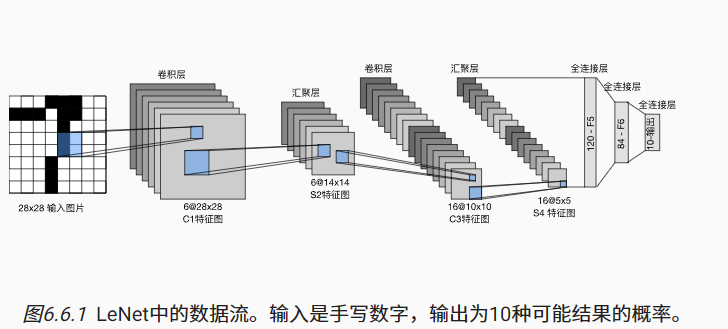

每个卷积块中的基本单元是一个卷积层、一个sigmoid激活函数和平均汇聚层。请注意，虽然ReLU和最大汇聚层更有效，但它们在20世纪90年代还没有出现。

每个卷积层使用5x5卷积核和一个sigmoid激活函数。这些层将输入映射到多个二维特征输出，通常同时增加通道的数量。第一卷积层有6个输出通道，而第二个卷积层有16个输出通道。每个2x2池操作（步幅2）通过空间下采样将维数减少4倍。卷积的输出形状由批量大小、通道数、高度、宽度决定。

为了将卷积块的输出传递给稠密块，我们必须在小批量中展平每个样本。换言之，我们将这个四维输入转换成全连接层所期望的二维输入。这里的二维表示的第一个维度索引小批量中的样本，第二个维度给出每个样本的平面向量表示。LeNet的稠密块有三个全连接层，分别有120、84和10个输出。因为我们在执行分类任务，所以输出层的10维对应于最后输出结果的数量。

通过下面的LeNet代码，可以看出用深度学习框架实现此类模型非常简单。我们只需要实例化一个Sequential块并将需要的层连接在一起。

In [ ]:
%pip install d2l
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

我们对原始模型做了一点小改动，去掉了最后一层的高斯激活。除此之外，这个网络与最初的LeNet-5一致。

下面，我们将一个大小为28x28的单通道（黑白）图像通过LeNet。通过在每一层打印输出的形状，我们可以检查模型，以确保其操作与我们期望的 图6.6.2一致。

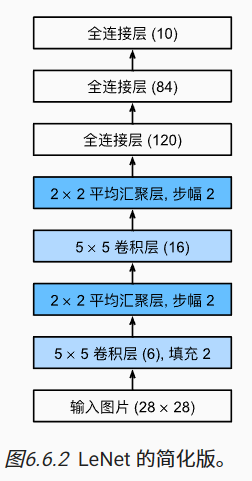

In [ ]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


请注意，在整个卷积块中，与上一层相比，每一层特征的高度和宽度都减小了。 第一个卷积层使用2个像素的填充，来补偿5x5卷积核导致的特征减少。 相反，第二个卷积层没有填充，因此高度和宽度都减少了4个像素。 随着层叠的上升，通道的数量从输入时的1个，增加到第一个卷积层之后的6个，再到第二个卷积层之后的16个。 同时，每个汇聚层的高度和宽度都减半。最后，每个全连接层减少维数，最终输出一个维数与结果分类数相匹配的输出。

## 6.6.2 模型训练

现在我们已经实现了LeNet，让我们看看LeNet在Fashion-MNIST数据集上的表现。

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

虽然卷积神经网络的参数较少，但与深度的多层感知机相比，它们的计算成本仍然很高，因为每个参数都参与更多的乘法。 通过使用GPU，可以用它加快训练。

为了进行评估，我们需要对 3.6节中描述的evaluate_accuracy函数进行轻微的修改。 由于完整的数据集位于内存中，因此在模型使用GPU计算数据集之前，我们需要将其复制到显存中。

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

为了使用GPU，我们还需要一点小改动。 与 3.6节中定义的train_epoch_ch3不同，在进行正向和反向传播之前，我们需要将每一小批量数据移动到我们指定的设备（例如GPU）上。

如下所示，训练函数train_ch6也类似于 3.6节中定义的train_ch3。 由于我们将实现多层神经网络，因此我们将主要使用高级API。 以下训练函数假定从高级API创建的模型作为输入，并进行相应的优化。 我们使用在 4.8.2.2节中介绍的Xavier随机初始化模型参数。 与全连接层一样，我们使用交叉熵损失函数和小批量随机梯度下降。

In [ ]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

现在，我们训练和评估LeNet-5模型。

loss 0.449, train acc 0.834, test acc 0.831
39619.2 examples/sec on cuda:0


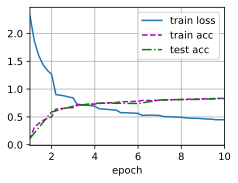

In [ ]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 6.6.3. 小结



*   卷积神经网络（CNN）是一类使用卷积层的网络。
*   在卷积神经网络中，我们组合使用卷积层、非线性激活函数和汇聚层。

*   为了构造高性能的卷积神经网络，我们通常对卷积层进行排列，逐渐降低其表示的空间分辨率，同时增加通道数。
*   在传统的卷积神经网络中，卷积块编码得到的表征在输出之前需由一个或多个全连接层进行处理。



